In [236]:
# Import libraries
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [237]:
# Load data
data = pd.read_csv('data_2_class.csv')
data = data.sample(frac=1).reset_index(drop=True)

In [238]:
# Preprocess data
print(data.isna().sum())
data.dropna(inplace=True)
data

plagiarized        0
original           0
plagiarism_type    0
dtype: int64


,plagiarized,original,plagiarism_type
0,"To keep players interested in a game, the diff...",Providing an appropriate difficulty level in a...,1
1,"Subsequently, the detected text region undergo...",Empathy is a specific moral aspect of human be...,0
2,The term artificial intelligence (AI) has gain...,Artificial intelligence (AI) has recently beco...,1
3,"As of 2021, more than 30 countries have releas...","As of 2021, more than 30 countries have releas...",0
4,Facial Expression Recognition (FER) is employe...,Facial Expression Recognition (FER) is utilize...,1
...,...,...,...
435,The expanding population results in a larger c...,The growing population also leads to a growing...,1
436,This paper presents the development of a compr...,International relations scholarship has long e...,0
437,"Autoimmune illnesses are long-lasting, complex...","Autoimmune diseases are chronic, multifactoria...",1
438,The main purpose is to improve the efficiency ...,The face is the most essential part of the hum...,0


In [239]:
# Load test data
test_data = pd.read_csv('test_data.csv')
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [240]:
# Preprocess test data
print(test_data.isna().sum())
test_data.dropna(inplace=True)
test_data

plagiarized        0
original           0
plagiarism_type    0
dtype: int64


,plagiarized,original,plagiarism_type
0,Machine learning (ML) is a form of artificial ...,Machine learning (ML) is a form of artificial ...,0
1,The utilization of Artificial Intelligence (AI...,The sphere of artificial intelligence (AI) tec...,1
2,This article delves into the intricacies of ad...,This article delves into the intricacies of ad...,0
3,Drug designing and development represent cruci...,Drug designing and development is an important...,1


In [241]:
# Assign data to variables
plagiarized_texts = data['plagiarized']
original_texts = data['original']
labels = data['plagiarism_type']

In [242]:
# Assign test data to variables
test_plagiarized_texts = test_data['plagiarized']
test_original_texts = test_data['original']
test_labels = test_data['plagiarism_type']

In [243]:
# Fill missing values
plagiarized_texts = plagiarized_texts.fillna('')
original_texts = original_texts.fillna('')

In [244]:
# Fill missing test values
test_plagiarized_texts = test_plagiarized_texts.fillna('')
test_original_texts = test_original_texts.fillna('')

In [245]:
# Define parameters
max_sequence_length = 800
embedding_dim = 300
num_classes = 2

In [246]:
# Combine texts
texts = (plagiarized_texts + ' ' + original_texts).astype(str)
texts[0]

"To keep players interested in a game, the difficulty level should be just right. One popular method for dynamically changing game elements to maximize player experience is called Dynamic Difficulty Adjustment (DDA). This study examines the literature on methods for changing the difficulty of video games according on a player's performance, feelings, or personality. In order to do this, we looked into DDA research that used player modeling strategies, machine learning techniques, data kinds for evaluating players' states, testbed game genres, and applications. The review's data sources included publications from conferences and journals that were published until September 2022. According to the results, the majority of research has demonstrated that DDA significantly affects variables like enjoyment, flow, motivation, engagement, and immersion. Furthermore, player modeling and machine learning approaches have also drawn increased interest in DDA design. However, given the growing popul

In [247]:
# Tokenize texts
tokens = [word for sentence in texts for word in sentence.split()]

In [248]:
# Get vocabulary size
vocabulary_size = len(set(tokens))
vocabulary_size

8405

In [249]:
# Tokenize texts
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(texts)

In [250]:
# Convert texts to sequences and pad them
sequences_plagiarized = tokenizer.texts_to_sequences(plagiarized_texts)
sequences_original = tokenizer.texts_to_sequences(original_texts)
padded_sequences_plagiarized = pad_sequences(sequences_plagiarized, maxlen=max_sequence_length)
padded_sequences_original = pad_sequences(sequences_original, maxlen=max_sequence_length)

In [251]:
# Convert test texts to sequences and pad them
test_sequences_plagiarized = tokenizer.texts_to_sequences(test_plagiarized_texts)
test_sequences_original = tokenizer.texts_to_sequences(test_original_texts)
test_padded_sequences_plagiarized = pad_sequences(test_sequences_plagiarized, maxlen=max_sequence_length)
test_padded_sequences_original = pad_sequences(test_sequences_original, maxlen=max_sequence_length)

In [252]:
# Define model (First version)
"""
input_layer1 = Input(shape=(max_sequence_length,))
input_layer2 = Input(shape=(max_sequence_length,))

embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)

lstm_layer = LSTM(units=50)

x1 = embedding_layer(input_layer1)
x1 = lstm_layer(x1)

x2 = embedding_layer(input_layer2)
x2 = lstm_layer(x2)

distance_layer = Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]),
                        output_shape=lambda _: (1,))([x1, x2])

output_layer = Dense(num_classes, activation='softmax')(distance_layer)

model = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)

model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
]
"""

"\ninput_layer1 = Input(shape=(max_sequence_length,))\ninput_layer2 = Input(shape=(max_sequence_length,))\n\nembedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)\n\nlstm_layer = LSTM(units=50)\n\nx1 = embedding_layer(input_layer1)\nx1 = lstm_layer(x1)\n\nx2 = embedding_layer(input_layer2)\nx2 = lstm_layer(x2)\n\ndistance_layer = Lambda(lambda x: tf.keras.backend.abs(x[0] - x[1]),\n                        output_shape=lambda _: (1,))([x1, x2])\n\noutput_layer = Dense(num_classes, activation='softmax')(distance_layer)\n\nmodel = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)\n\nmodel.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\ncallbacks = [\n    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),\n]\n"

In [253]:
# Define model (Second version)
"""
from keras.layers import LSTM, Embedding, Dense, Input, Concatenate, Dropout # type: ignore

# Define model
input_layer1 = Input(shape=(max_sequence_length,))
input_layer2 = Input(shape=(max_sequence_length,))

embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)

# First LSTM layer
lstm_layer1 = LSTM(units=100, return_sequences=True)
x1 = embedding_layer(input_layer1)
x1 = lstm_layer1(x1)

# Second LSTM layer
lstm_layer2 = LSTM(units=50)
x1 = lstm_layer2(x1)

# Repeat for the second input
x2 = embedding_layer(input_layer2)
x2 = lstm_layer1(x2)
x2 = lstm_layer2(x2)

# Concatenate the LSTM outputs
concatenated = Concatenate()([x1, x2])

# Add additional layers for processing
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

model.summary()
"""

"\nfrom keras.layers import LSTM, Embedding, Dense, Input, Concatenate, Dropout # type: ignore\n\n# Define model\ninput_layer1 = Input(shape=(max_sequence_length,))\ninput_layer2 = Input(shape=(max_sequence_length,))\n\nembedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)\n\n# First LSTM layer\nlstm_layer1 = LSTM(units=100, return_sequences=True)\nx1 = embedding_layer(input_layer1)\nx1 = lstm_layer1(x1)\n\n# Second LSTM layer\nlstm_layer2 = LSTM(units=50)\nx1 = lstm_layer2(x1)\n\n# Repeat for the second input\nx2 = embedding_layer(input_layer2)\nx2 = lstm_layer1(x2)\nx2 = lstm_layer2(x2)\n\n# Concatenate the LSTM outputs\nconcatenated = Concatenate()([x1, x2])\n\n# Add additional layers for processing\nx = Dense(128, activation='relu')(concatenated)\nx = Dropout(0.5)(x)\n\noutput_layer = Dense(num_classes, activation='softmax')(x)\n\nmodel = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)\n\nmodel.compile(optimizer='adam', loss='sparse_categ

In [254]:
# Define model (Third version)
# Define the model architecture
input_plagiarized = Input(shape=(max_sequence_length,))
input_original = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)

# Embedding sequences
embedded_plagiarized = embedding_layer(input_plagiarized)
embedded_original = embedding_layer(input_original)

# LSTM layers
lstm_layer = LSTM(128, return_sequences=True)

lstm_output_plagiarized = lstm_layer(embedded_plagiarized)
lstm_output_original = lstm_layer(embedded_original)

# Attention mechanism
attention = Dense(1, activation='tanh')
attention_scores_plagiarized = attention(lstm_output_plagiarized)
attention_scores_original = attention(lstm_output_original)
attention_weights_plagiarized = tf.keras.layers.Softmax(axis=1)(attention_scores_plagiarized)
attention_weights_original = tf.keras.layers.Softmax(axis=1)(attention_scores_original)
context_plagiarized = tf.keras.layers.Dot(axes=1)([attention_weights_plagiarized, lstm_output_plagiarized])
context_original = tf.keras.layers.Dot(axes=1)([attention_weights_original, lstm_output_original])

# Concatenate attention context with original and plagiarized LSTM outputs
merged_output = tf.keras.layers.Concatenate(axis=-1)([context_plagiarized, context_original])

# Dropout for regularization (TODO: ADDED FOR TESTING)
dropout_layer = Dropout(0.5)
merged_output = dropout_layer(merged_output)

# Batch normalization for stability (TODO: ADDED FOR TESTING)
batch_norm_layer = BatchNormalization()
merged_output = batch_norm_layer(merged_output)

# Dense layer for classification
output = Dense(num_classes, activation='softmax')(merged_output)

# Model
model = Model(inputs=[input_original, input_plagiarized], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [255]:
# Show the model architecture
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 800)]                0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 800)]                0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 800, 300)             2521500   ['input_23[0][0]',            
                                                                     'input_24[0][0]']            
                                                                                                  
 lstm_11 (LSTM)              (None, 800, 128)             219648    ['embedding_11[0][0]',  

In [256]:
# Run the model
history = model.fit([padded_sequences_plagiarized, padded_sequences_original], labels, epochs=30, 
                    batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=2)])

Epoch 1/30
11/11 [==============================] - 12s 956ms/step - loss: 0.8419 - accuracy: 0.4830 - val_loss: 0.6907 - val_accuracy: 0.6818
Epoch 2/30
11/11 [==============================] - 10s 873ms/step - loss: 0.7886 - accuracy: 0.5682 - val_loss: 0.6889 - val_accuracy: 0.5341
Epoch 3/30
11/11 [==============================] - 9s 857ms/step - loss: 0.6595 - accuracy: 0.6506 - val_loss: 0.6780 - val_accuracy: 0.5341
Epoch 4/30
11/11 [==============================] - 10s 909ms/step - loss: 0.3100 - accuracy: 0.8693 - val_loss: 0.5337 - val_accuracy: 0.8977
Epoch 5/30
11/11 [==============================] - 11s 958ms/step - loss: 0.0962 - accuracy: 0.9773 - val_loss: 0.5540 - val_accuracy: 1.0000
Epoch 6/30
11/11 [==============================] - 10s 949ms/step - loss: 0.0339 - accuracy: 0.9943 - val_loss: 0.3923 - val_accuracy: 1.0000
Epoch 7/30
11/11 [==============================] - 10s 941ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.3337 - val_accuracy: 0.9545


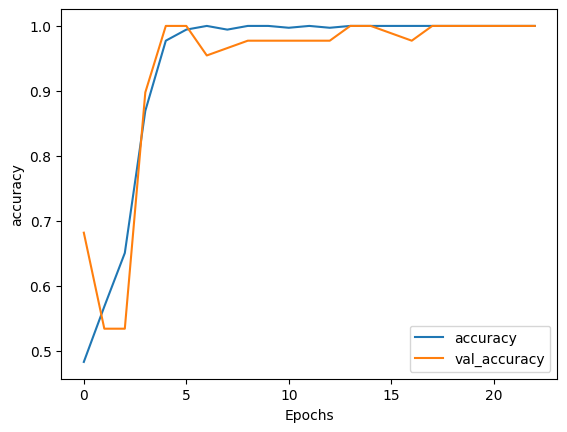

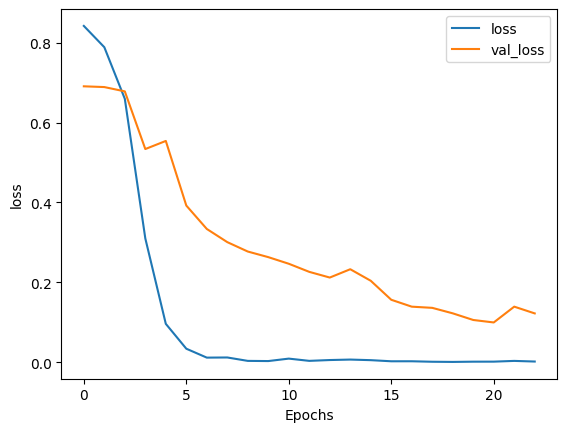

In [257]:
# Visualizar la precisión y la pérdida de entrenamiento y prueba
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.legend([string, 'val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [258]:
# Test the model
test_loss, test_accuracy = model.evaluate([test_padded_sequences_original, test_padded_sequences_plagiarized], test_labels)

1/1 [==============================] - 0s 188ms/step - loss: 0.7230 - accuracy: 0.5000


In [259]:
# Preprocess function
def preprocess(sentence):
  sequence = pad_sequences(tokenizer.texts_to_sequences([sentence]), maxlen=max_sequence_length)
  return sequence

In [260]:
# org-076.txt and FID-01.txt -> 0
prediction = model.predict([
    preprocess("This article delves into the intricacies of adaptive fuzzy event-triggered formation tracking control for nonholonomic multirobot systems characterized by infinite actuator faults and range constraints. To address these issues, we leverage the power of fuzzy logic systems (FLSs) and employ adaptive methods to approximate unknown nonlinear functions and uncertain parameters present in robotic dynamics. In the course of information exploration, the problems of collision avoidance and connectivity maintenance are ever present due to limitations of distance and visual fields. In this regard, we introduce a general barrier function and prescribed performance methodology to tackle constrained range impediments effectively. Furthermore, to reduce the number of controller executions and compensate for any effect arising from infinite actuator failures, robots engage with their leader at the moment of actuator faults using fewer network communication resources yet maintain uninterrupted tracking of the desired trajectory generated by the leader. With the aid of the dynamic surface technology, we propose a decentralized adaptive event-triggering fault-tolerant (ETFT) formation control strategy. We guarantee that all signals are semi-global uniformly ultimately bounded (SGUUB). Ultimately, we demonstrate the practical feasibility of the ETFT control strategy for nonholonomic multirobot systems."),
    preprocess("This article delves into the intricacies of adaptive fuzzy event-triggered formation tracking control for nonholonomic multirobot systems characterized by infinite actuator faults and range constraints. Traditional cheating detection methods have many disadvantages, such as difficult to detect covert equipment cheating, multi-source cheating, difficult to distinguish plagiarists from plagiarists, difficult to distinguish plagiarists from victims, or plagiarism from coincidences. To address these issues, we leverage the power of fuzzy logic systems (FLSs) and employ adaptive methods to approximate unknown nonlinear functions and uncertain parameters present in robotic dynamics. In the course of information exploration, the problems of collision avoidance and connectivity maintenance are ever present due to limitations of distance and visual fields. In this paper, the concept of knowledge point mastery Index is introduced to measure students’ mastery of a certain knowledge point, and a test method of cheating based on improved cognitive diagnostic model is proposed. Furthermore, to reduce the number of controller executions and compensate for any effect arising from infinite actuator failures, robots engage with their leader at the moment of actuator faults using fewer network communication resources yet maintain uninterrupted tracking of the desired trajectory generated by the leader. We guarantee that all signals are semi-global uniformly ultimately bounded (SGUUB). Ultimately, we demonstrate the practical feasibility of the ETFT control strategy for nonholonomic multirobot systems. The experiments show that the precision and recall rate of this method are significantly higher than those of the method based on the false-same rate, the method based on the false-same rate and the right-same rate and the method based on the Person-Fit index.")])
prediction

1/1 [==============================] - 1s 581ms/step


array([[[0.30181453, 0.6981855 ]]], dtype=float32)

In [261]:
# org-016.txt and FID-03.txt -> 1
prediction = model.predict([
    preprocess("At present, the application of Artificial Intelligence (AI) in industrial control, smart home and other fields has received good response. However, AI technology has certain requirements for computer performance, and also faces problems in network security, data analysis, human-computer interaction, etc. At present, the visual platform of embedded system has achieved remarkable results in practical applications, but its development has been seriously hampered by problems such as low overall development efficiency and unstable system performance. This paper designed an EP Vision System (VS) based on AI technology. The platform combined the embedded hardware design with the Support Vector Machine (SVM) algorithm to realize the intelligent robot interaction and target detection functions. The test results showed that when other conditions were the same, students and experts had 83.5% and 90% positive evaluations of System X, and 16.5% and 10% negative evaluations respectively. However, their positive evaluation of System Y only accounted for 19% and 4%, while the negative evaluation accounted for 81% and 96%. The proportion of positive evaluation of System X was much higher than that of System Y, which indicated that System X can meet the actual application requirements and improve the system recognition efficiency to a certain extent. It showed the positive relationship between AI technology and EP VS."), 
    preprocess("At present, the application of Artificial Intelligence (AI) in industrial control, smart home and other fields has received good response. However, AI technology has certain requirements for computer performance, and also faces problems in network security, data analysis, human-computer interaction, etc. At present, the visual platform of embedded system has achieved remarkable results in practical applications, but its development has been seriously hampered by problems such as low overall development efficiency and unstable system performance. The test results showed that when other conditions were the same, students and experts had 83.5% and 90% positive evaluations of System X, and 16.5% and 10% negative evaluations respectively. This paper designed an EP Vision System (VS) based on AI technology. The platform combined the embedded hardware design with the Support Vector Machine (SVM) algorithm to realize the intelligent robot interaction and target detection functions. It showed the positive relationship between AI technology and EP VS. The proportion of positive evaluation of System X was much higher than that of System Y, which indicated that System X can meet the actual application requirements and improve the system recognition efficiency to a certain extent. However, their positive evaluation of System Y only accounted for 19% and 4%, while the negative evaluation accounted for 81% and 96%. However, their positive evaluation of System Y only accounted for 19% and 4%, while the negative evaluation accounted for 81% and 96%. ")])
prediction

1/1 [==============================] - 0s 66ms/step


array([[[0.74751353, 0.2524865 ]]], dtype=float32)

In [262]:
# org-109.txt and FID-09.txt -> 2
prediction = model.predict([
    preprocess("Drug designing and development is an important area of research for pharmaceutical companies and chemical scientists. However, low efficacy, off-target delivery, time consumption, and high cost impose a hurdle and challenges that impact drug design and discovery. Further, complex and big data from genomics, proteomics, microarray data, and clinical trials also impose an obstacle in the drug discovery pipeline. Artificial intelligence and machine learning technology play a crucial role in drug discovery and development. In other words, artificial neural networks and deep learning algorithms have modernized the area. Machine learning and deep learning algorithms have been implemented in several drug discovery processes such as peptide synthesis, structure-based virtual screening, ligand-based virtual screening, toxicity prediction, drug monitoring and release, pharmacophore modeling, quantitative structure–activity relationship, drug repositioning, polypharmacology, and physiochemical activity. Evidence from the past strengthens the implementation of artificial intelligence and deep learning in this field. Moreover, novel data mining, curation, and management techniques provided critical support to recently developed modeling algorithms. In summary, artificial intelligence and deep learning advancements provide an excellent opportunity for rational drug design and discovery process, which will eventually impact mankind. "),
    preprocess("Drug designing and development represent crucial areas of research for pharmaceutical companies and chemical scientists. However, challenges such as low efficacy, off-target delivery, time consumption, and high cost hinder progress in drug design and discovery. Additionally, the complexity and volume of data from genomics, proteomics, microarray data, and clinical trials pose significant obstacles in the drug discovery pipeline. Artificial intelligence (AI) and machine learning (ML) technologies have revolutionized drug discovery and development, particularly through the use of artificial neural networks and deep learning algorithms. These technologies have modernized various processes in drug discovery, including peptide synthesis, structure-based virtual screening, ligand-based virtual screening, toxicity prediction, drug monitoring and release, pharmacophore modeling, quantitative structure–activity relationship, drug repositioning, polypharmacology, and physiochemical activity. Historical evidence supports the implementation of AI and deep learning in drug discovery. Furthermore, novel data mining, curation, and management techniques have provided critical support to newly developed modeling algorithms. In summary, advancements in AI and deep learning offer significant opportunities for rational drug design and discovery, ultimately benefiting mankind. Drug designing and development is an important area of research for pharmaceutical companies and chemical scientists. However, low efficacy, off-target delivery, time consumption, and high cost impose a hurdle and challenges that impact drug design and discovery. Further, complex and big data from genomics, proteomics, microarray data, and clinical trials also impose an obstacle in the drug discovery pipeline. Artificial intelligence and machine learning technology play a crucial role in drug discovery and development. In other words, artificial neural networks and deep learning algorithms have modernized the area. Machine learning and deep learning algorithms have been implemented in several drug discovery processes such as peptide synthesis, structure-based virtual screening, ligand-based virtual screening, toxicity prediction, drug monitoring and release, pharmacophore modeling, quantitative structure–activity relationship, drug repositioning, polypharmacology, and physiochemical activity. Evidence from the past strengthens the implementation of artificial intelligence and deep learning in this field. Moreover, novel data mining, curation, and management techniques provided critical support to recently developed modeling algorithms. In summary, artificial intelligence and deep learning advancements provide an excellent opportunity for rational drug design and discovery process, which will eventually impact mankind. ")])
prediction

1/1 [==============================] - 0s 66ms/step


array([[[0.16882844, 0.8311716 ]]], dtype=float32)